In [17]:
from openai import OpenAI
import os
from sklearn.manifold import TSNE 
import numpy as np
import matplotlib.pyplot as plt 
from scipy.spatial import distance

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

# What are embeddings?

## Creating embeddings

In [18]:
response = client.embeddings.create(
    model="text-embedding-ada-002",
    input="Embeddings are a numerical representation of text that can be used to measure the relatedness between two pieces of text."
)

# Convert the response into a dictionary
response_dict = response.model_dump()

print(response_dict)

{'data': [{'embedding': [-0.026734447106719017, 0.0021900031715631485, 0.010457738302648067, -0.02761802077293396, -0.002014865865930915, -0.011284511536359787, 0.002175802830606699, -0.010666009038686752, -0.01319050882011652, -0.01628302037715912, 0.0011959815165027976, 0.02973860129714012, -0.019438644871115685, 0.007428338751196861, -0.011713676154613495, 0.032338835299015045, 0.014099327847361565, -0.0012046594638377428, 0.013001170940697193, -0.02489156275987625, -0.0281229205429554, -0.01097526028752327, -0.02375553734600544, -0.001704036956652999, -0.0219378974288702, -0.001976998522877693, 0.02119317092001438, -0.02374291606247425, -0.00891148205846548, -0.01980469562113285, 0.007706033997237682, -0.020978588610887527, -0.024033233523368835, -0.017116105183959007, -0.020271729677915573, 0.009094508364796638, 0.009832924231886864, -0.036125585436820984, 0.02991531603038311, -0.014351777732372284, -0.00565172266215086, 0.01799967885017395, 0.00768710020929575, -0.025434330105781

In [19]:
print(response_dict['usage']['total_tokens'])

23


In [20]:
print(response_dict['data'][0]['embedding'])

[-0.026734447106719017, 0.0021900031715631485, 0.010457738302648067, -0.02761802077293396, -0.002014865865930915, -0.011284511536359787, 0.002175802830606699, -0.010666009038686752, -0.01319050882011652, -0.01628302037715912, 0.0011959815165027976, 0.02973860129714012, -0.019438644871115685, 0.007428338751196861, -0.011713676154613495, 0.032338835299015045, 0.014099327847361565, -0.0012046594638377428, 0.013001170940697193, -0.02489156275987625, -0.0281229205429554, -0.01097526028752327, -0.02375553734600544, -0.001704036956652999, -0.0219378974288702, -0.001976998522877693, 0.02119317092001438, -0.02374291606247425, -0.00891148205846548, -0.01980469562113285, 0.007706033997237682, -0.020978588610887527, -0.024033233523368835, -0.017116105183959007, -0.020271729677915573, 0.009094508364796638, 0.009832924231886864, -0.036125585436820984, 0.02991531603038311, -0.014351777732372284, -0.00565172266215086, 0.01799967885017395, 0.00768710020929575, -0.025434330105781555, -0.0047018798068165

## Investigating the vector space

In [21]:
products = [
    {'title': 'Smartphone X1', 'short_description': 'The latest flagship smartphone with AI-powered features and 5G connectivity.', 'price': 799.99, 'category': 'Electronics', 'features': ['6.5-inch AMOLED display', 'Quad-camera system with 48MP main sensor', 'Face recognition and fingerprint sensor', 'Fast wireless charging']}, 
    {'title': 'Luxury Diamond Necklace', 'short_description': 'Elegant necklace featuring genuine diamonds, perfect for special occasions.', 'price': 1499.99, 'category': 'Beauty', 'features': ['18k white gold chain', '0.5 carat diamond pendant', 'Adjustable chain length', 'Gift box included']}, 
    {'title': 'RC Racing Car', 'short_description': 'High-speed remote-controlled racing car for adrenaline-packed fun.', 'price': 89.99, 'category': 'Toys', 'features': ['Top speed of 30 mph', 'Responsive remote control', 'Rechargeable battery', 'Durable construction']}, 
    {'title': 'Ultra HD 4K TV', 'short_description': 'Immerse yourself in stunning visuals with this 65-inch 4K TV.', 'price': 1299.99, 'category': 'Electronics', 'features': ['65-inch 4K UHD display', 'Dolby Vision and HDR10+ support', 'Smart TV with streaming apps', 'Voice remote included']}, 
    {'title': 'Glowing Skin Serum', 'short_description': 'Revitalize your skin with this nourishing serum for a radiant glow.', 'price': 39.99, 'category': 'Beauty', 'features': ['Hyaluronic acid and vitamin C', 'Hydrates and reduces fine lines', 'Suitable for all skin types', 'Cruelty-free']}, 
    {'title': 'LEGO Space Shuttle', 'short_description': 'Build your own space adventure with this LEGO space shuttle set.', 'price': 49.99, 'category': 'Toys', 'features': ['359 pieces for creative building', 'Astronaut minifigure included', 'Compatible with other LEGO sets', 'For ages 7+']}, 
    {'title': 'Wireless Noise-Canceling Headphones', 'short_description': 'Enjoy immersive audio and block out distractions with these headphones.', 'price': 199.99, 'category': 'Electronics', 'features': ['Active noise cancellation', 'Bluetooth 5.0 connectivity', 'Long-lasting battery life', 'Foldable design for portability']}, 
    {'title': 'Luxury Perfume Gift Set', 'short_description': 'Indulge in a collection of premium fragrances with this gift set.', 'price': 129.99, 'category': 'Beauty', 'features': ['Five unique scents', 'Elegant packaging', 'Perfect gift for fragrance enthusiasts', 'Variety of fragrance notes']}, 
    {'title': 'Remote-Controlled Drone', 'short_description': 'Take to the skies and capture stunning aerial footage with this drone.', 'price': 299.99, 'category': 'Electronics', 'features': ['4K camera with gimbal stabilization', 'GPS-assisted flight', 'Remote control with smartphone app', 'Return-to-home function']}, 
    {'title': 'Luxurious Spa Gift Basket', 'short_description': 'Pamper yourself or a loved one with this spa gift basket full of relaxation goodies.', 'price': 79.99, 'category': 'Beauty', 'features': ['Bath bombs, body lotion, and more', 'Aromatherapy candles', 'Reusable wicker basket', 'Great for self-care']}, 
    {'title': 'Robot Building Kit', 'short_description': 'Learn robotics and coding with this educational robot building kit.', 'price': 59.99, 'category': 'Toys', 'features': ['Build and program your own robot', 'STEM learning tool', 'Compatible with Scratch and Python', 'Ideal for young inventors']}, 
    {'title': 'High-Performance Gaming Laptop', 'short_description': 'Dominate the gaming world with this powerful gaming laptop.', 'price': 1499.99, 'category': 'Electronics', 'features': ['Intel Core i7 processor', 'NVIDIA RTX graphics', '144Hz refresh rate display', 'RGB backlit keyboard']}, 
    {'title': 'Natural Mineral Makeup Set', 'short_description': 'Enhance your beauty with this mineral makeup set for a flawless look.', 'price': 34.99, 'category': 'Beauty', 'features': ['Mineral foundation and eyeshadows', 'Non-comedogenic and paraben-free', 'Cruelty-free and vegan', 'Includes makeup brushes']}, 
    {'title': 'Interactive Robot Pet', 'short_description': 'Adopt your own robot pet that responds to your voice and touch.', 'price': 79.99, 'category': 'Toys', 'features': ['Realistic pet behaviors', 'Voice recognition and touch sensors', 'Teaches responsibility and empathy', 'Rechargeable battery']}, 
    {'title': 'Smart Thermostat', 'short_description': "Control your home's temperature and save energy with this smart thermostat.", 'price': 129.99, 'category': 'Electronics', 'features': ['Wi-Fi connectivity', 'Energy-saving features', 'Compatible with voice assistants', 'Easy installation']}, 
    {'title': 'Designer Makeup Brush Set', 'short_description': 'Upgrade your makeup routine with this premium designer brush set.', 'price': 59.99, 'category': 'Beauty', 'features': ['High-quality synthetic bristles', 'Chic designer brush handles', 'Complete set for all makeup needs', 'Includes stylish carrying case']}, 
    {'title': 'Remote-Controlled Dinosaur Toy', 'short_description': 'Roar into action with this remote-controlled dinosaur toy with lifelike movements.', 'price': 49.99, 'category': 'Toys', 'features': ['Realistic dinosaur sound effects', 'Walks and roars like a real dinosaur', 'Remote control included', 'Educational and entertaining']}, 
    {'title': 'Wireless Charging Dock', 'short_description': 'Charge your devices conveniently with this sleek wireless charging dock.', 'price': 39.99, 'category': 'Electronics', 'features': ['Qi wireless charging technology', 'Supports multiple devices', 'LED charging indicators', 'Compact and stylish design']}, 
    {'title': 'Luxury Skincare Set', 'short_description': 'Elevate your skincare routine with this luxurious skincare set.', 'price': 179.99, 'category': 'Beauty', 'features': ['Premium anti-aging ingredients', 'Hydrating and rejuvenating formulas', 'Complete skincare regimen', 'Elegant packaging']}
]

product_descriptions = [product['short_description'] for product in products]

response = client.embeddings.create(   
    model="text-embedding-ada-002",   
    input=product_descriptions
)
response_dict = response.model_dump()

for i, product in enumerate(products):
    product['embedding'] = response_dict['data'][i]['embedding']
    
print(products[0].items())

dict_items([('title', 'Smartphone X1'), ('short_description', 'The latest flagship smartphone with AI-powered features and 5G connectivity.'), ('price', 799.99), ('category', 'Electronics'), ('features', ['6.5-inch AMOLED display', 'Quad-camera system with 48MP main sensor', 'Face recognition and fingerprint sensor', 'Fast wireless charging']), ('embedding', [-0.014646673575043678, 0.0035414539743214846, 0.004343966953456402, -0.017180925235152245, -0.003804626176133752, 0.01502356305718422, -0.021716585382819176, 0.0002928197500295937, -0.016310183331370354, -0.014880605041980743, 0.028799494728446007, 0.01095576398074627, -0.009357236325740814, -0.02141767367720604, -0.018298596143722534, -0.010578875429928303, 0.0120604382827878, -0.012307364493608475, 0.021378684788942337, -0.02023502252995968, -0.01605025865137577, 0.006559812463819981, 0.008233068510890007, 0.005971736274659634, 0.0057508014142513275, -0.010871289297938347, 0.006007475778460503, -0.0005706127267330885, 0.00714788

## Visualizing the embedded descriptions

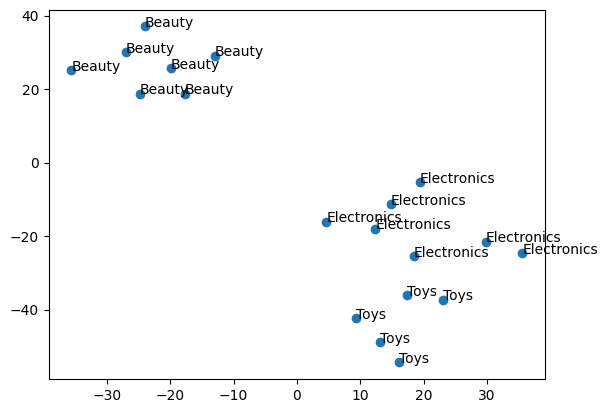

In [22]:
categories = [product['category'] for product in products]
embeddings = [product['embedding'] for product in products]

tsne = TSNE(n_components=2, perplexity=5)
embeddings_2d = tsne.fit_transform(np.array(embeddings))

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

for i, category in enumerate(categories):
    plt.annotate(category, (embeddings_2d[i, 0], embeddings_2d[i, 1]))

plt.show()

# Text similarity

## More repeatable embeddings

In [23]:
short_description = "The latest flagship smartphone with AI-powered features and 5G connectivity."
list_of_descriptions = [
  'Charge your devices conveniently with this sleek wireless charging dock.', 
  'Elevate your skincare routine with this luxurious skincare set.'
]

def create_embeddings(texts):
  response = client.embeddings.create(
    model="text-embedding-ada-002",
    input=texts
  )
  response_dict = response.model_dump()
  
  return [data['embedding'] for data in response_dict['data']]

print(create_embeddings(short_description)[0])

print(create_embeddings(list_of_descriptions)[0])

[-0.014657561667263508, 0.0035799273755401373, 0.004385573323816061, -0.017256420105695724, -0.0038398131728172302, 0.014995412901043892, -0.02175244502723217, 0.0002472976048011333, -0.016333825886249542, -0.014735527336597443, 0.028795350342988968, 0.010986673645675182, -0.009349392727017403, -0.02144058234989643, -0.01834793947637081, -0.010551365092396736, 0.012078193947672844, -0.012292600236833096, 0.021479563787579536, -0.020271094515919685, -0.016125915572047234, 0.006536128930747509, 0.008173409849405289, 0.006029351614415646, 0.005610285326838493, -0.010817748494446278, 0.005941640119999647, -0.0006403749575838447, 0.0071663521230220795, -0.002579367021098733, 0.02136261574923992, -0.0019312766380608082, -0.023259783163666725, 0.003998993430286646, -0.01902364380657673, 0.025546777993440628, 0.011116616427898407, -0.012195142917335033, 0.021999336779117584, -0.015918007120490074, 0.02167447842657566, 0.003791084745898843, 0.0017850908916443586, 0.01669766567647457, -0.0312642

## Finding the most similar product

In [24]:
search_text = "soap"
search_embedding = create_embeddings("soap")[0]

distances = []
for product in products:
  dist = distance.cosine(search_embedding, product['embedding'])
  distances.append(dist)
  
min_dist_ind = np.argmin(distances)
print(products[min_dist_ind]['short_description'])

Elevate your skincare routine with this luxurious skincare set.
